# Weather file - raw data process
- Main task: reading in raw weather data from two sources and combine all output into .csv format <br/>
- Data source: 
    1. NOAA Integrated Surface Data (ISH): https://www.ncdc.noaa.gov/isd/data-access
    2. National Solar Radiation Database (NSRD): https://rredc.nrel.gov/solar/old_data/nsrdb/
        - seems like can no longer reach this website (200626)
        - new data access here: https://nsrdb.nrel.gov/data-sets/archives.html
- Main output: 
    1. met data: df_temp_all, df_rh_all, df_precip_all
    2. solarad data: df_solrad_all

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import time 
import datetime

### Step 1. Hourly Meteorology Data - ISH
- Main task: 
    - Read in and process raw met data
    - Store output as dataframe and save as .csv
- Main input: 
    - /data/**ISH/***
- Main output: 
    - /weadata/**temp_all_6190.csv**
    - /weadata/**precip_all_6190.csv**
    - /weadata/**rh_all_6190.csv**

#### 1.1: function calculating RH with temp and dew point temp input
Following the Clausius-Clapeyron relationship

In [52]:
# Creating Clausius-Clapeyron function

def CC(temp, temp_dew):
    """
    function that calculates relative humidity with temperature and dew point temperature
    temperautre input units: ˚C
    """
    # constant parameters
    Tref = 273.15  # reference temperature
    Es_Tref = 6.11 # saturation vapor pressure at reference temperature (mb)
    Lv = 2.5e+06   # latent heat of vaporation (J/kg)
    Rv = 461       # gas constant for moist air (J/K*kg)
    
    # transformed temperature inputs
    Tair = temp + Tref
    Tdew = temp_dew + Tref
    
    # Clausius-Clapeyron relation
    es = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Tair))
    e = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Tdew))
    rh = round(e/es,4)
    
    return(rh)

#### 1.2: read in individual met files and parse out data needed (1961-1990)

In [116]:
%%time 
# run time ~30 mins

# timing related settings
years = np.arange(1961, 1991) # timeframe in which we have weather data
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '03-01-', '11-30-' # setting a pretty borad range for growing season

# setting up np.read_fwf arguments
colnames = ['time', 'temp', 'temp_quality', 'dew_temp', 'dtemp_quality', 'precip', 
            'precip_time', 'precip_depth', 'precip_quality', 'precip_perhr', 'rh']
colspecs = [(15,25), (87,92), (92,93), (93,98), (98,99), (105,8193)]


# empty dataframes to store data from all site-years
df_temp_all = pd.DataFrame()
df_rh_all = pd.DataFrame()
df_precip_all = pd.DataFrame()

# reading in all weather data and storing as dataframe
for year in years:
    print(year) # output to track code progress
    times = pd.date_range(season_start + str(year), season_end + str(year) + ' 23:00:00', freq='1H')
    fnames = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/*')
    
    # creating dataframes to store all site data for an individual year
    df_temp_sites = pd.DataFrame(index=times)
    df_rh_sites = pd.DataFrame(index=times)
    df_precip_sites = pd.DataFrame(index=times)
    
    for name in fnames:
        # WBAN site name 
        site_id = name.split('/')[-1].split('-')[-2]
        
        # read in individual files
        df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                         encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                         parse_dates=True, date_parser=dateparse)
    
        # remove duplicated hours, keeping only the first measurement per hour
        df = df[df.index.duplicated(keep='first') == False]
        
        # add in missing time values (corrects for leap years) and keeps only growing season
        df = df.reindex(times, fill_value=np.nan)
        
        # finding precip data
        df.precip_time = df[df['precip'].str.find('ADDAA1')!=-1]['precip'].str.split('ADDAA1').str.get(1).str.slice(0,2).astype(float)
        df.precip_depth = df[df['precip'].str.find('ADDAA1')!=-1]['precip'].str.split('ADDAA1').str.get(1).str.slice(2, 6).astype(float)
        df.precip_quality = df[df['precip'].str.find('ADDAA1')!=-1]['precip'].str.split('ADDAA1').str.get(1).str.slice(7,8).astype(float)
            
        # filtering out weather data based on quality code (data manual p.26)
        # removing data with code 3 (Erroneous) or 7 (Erroneous, data originate from an NCEI data source)
        # - temp
        quality_temp = (df.temp_quality=='3') | (df.temp_quality=='7')
        rows_temp = df[quality_temp].index
        df.loc[rows_temp, 'temp'] = np.nan
        # - dew temp
        quality_dtemp = (df.dtemp_quality=='3') | (df.dtemp_quality=='7')
        rows_dtemp = df[quality_dtemp].index
        df.loc[rows_dtemp, 'dew_temp'] = np.nan
        # - precip
        quality_precip = (df.precip_quality=='3') | (df.precip_quality=='7')
        rows_precip = df[quality_precip].index
        df.loc[rows_precip, 'precip'] = np.nan        

        # replacing missing data with NaN
        df.temp = df.temp.replace({9999: np.nan})
        df.dew_temp = df.dew_temp.replace({9999: np.nan})
        df.precip_time = df.precip_time.replace({99: np.nan})
        df.precip_depth = df.precip_depth.replace({9999: np.nan})
        
        # calculating hourly precip depth
        df.precip_perhr = df.precip_depth/df.precip_time
        df.precip_perhr = df.precip_perhr.replace({np.inf: np.nan}) # accounting for cases where precip_hr = 0
                                                                    # which produces infinite precip_perhr

        # converting units 
        df.temp = df.temp/10
        df.dew_temp = df.dew_temp/10
        df.precip_perhr = df.precip_perhr/10
        
        # calculating RH through Clausius Clapeyron
        df.rh = CC(df.temp, df.dew_temp)*100
        if df[df.rh>100].rh.sum() > 100:
            print('rh > 100: ', year, name)        

        # combining weather data into individual dataframes
        df_temp = pd.DataFrame({site_id: df.temp}, index= times)
        df_rh = pd.DataFrame({site_id: df.rh}, index=times)
        df_precip = pd.DataFrame({site_id: df.precip_perhr}, index=times)
        
        df_temp_sites = pd.concat([df_temp_sites, df_temp], axis= 1, sort=True)
        df_rh_sites = pd.concat([df_rh_sites, df_rh], axis=1, sort=True)
        df_precip_sites = pd.concat([df_precip_sites, df_precip], axis=1, sort=True)

    # combining all site-years data together
    df_temp_all = pd.concat([df_temp_all, df_temp_sites], sort=True)
    df_rh_all = pd.concat([df_rh_all, df_rh_sites], sort=True)
    df_precip_all = pd.concat([df_precip_all, df_precip_sites], sort=True)

#df_temp_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/temp_6190.csv')
#df_precip_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/precip_6190.csv')
#df_rh_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/rh_6190.csv')

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
CPU times: user 28min 29s, sys: 1min 5s, total: 29min 35s
Wall time: 31min 54s


#### 1.3: read in individual met files and parse out data needed (1991-2010)

In [53]:
# reading in USAF site information - from solar radiation dataset
df_sites = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv')
df_sites.head()

# select only class 1 stations (see NSRDB manual p.7-8 for more details)
df_class1 = df_sites[(df_sites['CLASS'] == 1)]
sites_class1 = list(df_class1.USAF) # station list with class 1 quality

In [55]:
%%time

# timing related settings
years = np.arange(1991, 2011) # timeframe in which we have weather data
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '03-01-', '11-30-' # setting a pretty borad range for growing season

# setting up np.read_fwf arguments
colnames = ['time', 'temp', 'temp_quality', 'dew_temp', 'dtemp_quality', 'precip', 
            'precip_time', 'precip_depth', 'precip_quality', 'precip_perhr', 'rh']
colspecs = [(15,25), (87,92), (92,93), (93,98), (98,99), (105,8193)]

# empty dataframes to store data from all site-years
df_temp_all = pd.DataFrame()
df_rh_all = pd.DataFrame()
df_precip_all = pd.DataFrame()

# reading in all weather data and storing as dataframe
for year in years:
    print(year) # output to track code progress
    times = pd.date_range(season_start + str(year), season_end + str(year) + ' 23:00:00', freq='1H')
    
    # creating dataframes to store all site data for an individual year
    df_temp_sites = pd.DataFrame(index=times)
    df_rh_sites = pd.DataFrame(index=times)
    df_precip_sites = pd.DataFrame(index=times)
    
    for site in sites_class1:
        # selecting for file associated with specified site
        file = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/' + str(site) + '-*')
        
        if len(file) == 0: # when specified site does not exist for current year
            continue # skip the following code and move on to the next site in the for loop
        elif len(file) == 1:
            name = file[0]
        else: # when specified USAF site has more than one WBAN ID, resulting in more than one unique site
            print('choosing from multiple files: ', file)
            name = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/' + str(site) + '-99999-*')[0]
            # for cases when a USAF station ID is linked to two WBAN IDs, select the one in which WBAN is listed as 99999
            
        # reading in raw weather data as fixed-width data format
        df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                         encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                         parse_dates=True, date_parser=dateparse)
        # remove duplicated hours, keeping only the first measurement per hour
        df = df[df.index.duplicated(keep='first') == False]

        # add in missing time values (corrects for leap years) and keeps only growing season
        df = df.reindex(times, fill_value=np.nan)

        # finding precip data
        df.precip_time = df[df['precip'].str.find('ADDAA1')!=-1]['precip'].str.split('ADDAA1').str.get(1).str.slice(0,2).astype(float)
        df.precip_depth = df[df['precip'].str.find('ADDAA1')!=-1]['precip'].str.split('ADDAA1').str.get(1).str.slice(2, 6).astype(float)
        df.precip_quality = df[df['precip'].str.find('ADDAA1')!=-1]['precip'].str.split('ADDAA1').str.get(1).str.slice(7,8)
                
        # filtering out weather data based on quality code (data manual p.26)
        # removing data with code 3 (Erroneous) or 7 (Erroneous, data originate from an NCEI data source)
        # - temp
        quality_temp = (df.temp_quality=='3') | (df.temp_quality=='7')
        rows_temp = df[quality_temp].index
        df.loc[rows_temp, 'temp'] = np.nan
        # - dew temp
        quality_dtemp = (df.dtemp_quality=='3') | (df.dtemp_quality=='7')
        rows_dtemp = df[quality_dtemp].index
        df.loc[rows_dtemp, 'dew_temp'] = np.nan
        # - precip
        quality_precip = (df.precip_quality=='3') | (df.precip_quality=='7')
        rows_precip = df[quality_precip].index
        df.loc[rows_precip, 'precip'] = np.nan

        # replacing missing values with NANs                    
        df.temp = df.temp.replace({9999: np.nan})
        df.dew_temp = df.dew_temp.replace({9999: np.nan})
        df.precip_time = df.precip_time.replace({99: np.nan})
        df.precip_depth = df.precip_depth.replace({9999: np.nan})

        # calculating hourly precip depth
        df.precip_perhr = df.precip_depth/df.precip_time
        df.precip_perhr = df.precip_perhr.replace({np.inf: np.nan}) # accounting for cases where precip_hr = 0
                                                                    # which produces infinite precip_perhr

        # converting units 
        df.temp = df.temp/10
        df.dew_temp = df.dew_temp/10
        df.precip_perhr = df.precip_perhr/10

        # calculating RH through Clausius Clapeyron
        df.rh = CC(df.temp, df.dew_temp)*100
        if df[df.rh>100].rh.sum() > 100:
            print(site, year)

        # combining weather data into individual dataframes
        df_temp = pd.DataFrame({site: df.temp}, index= times)
        df_rh = pd.DataFrame({site: df.rh}, index=times)
        df_precip = pd.DataFrame({site: df.precip_perhr}, index=times)

        df_temp_sites = pd.concat([df_temp_sites, df_temp], axis= 1, sort=True)
        df_rh_sites = pd.concat([df_rh_sites, df_rh], axis=1, sort=True)
        df_precip_sites = pd.concat([df_precip_sites, df_precip], axis=1, sort=True)       

    # combining all site-years data together
    df_temp_all = pd.concat([df_temp_all, df_temp_sites], sort=True)
    df_rh_all = pd.concat([df_rh_all, df_rh_sites], sort=True)
    df_precip_all = pd.concat([df_precip_all, df_precip_sites], sort=True)

#df_temp_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/temp_9110_class1.csv')
#df_precip_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/precip_9110_class1.csv')
#df_rh_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/rh_9110_class1.csv')

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2000/724665-93010-2000', '/home/disk/eos8/ach315/data/ISH/2000/724665-99999-2000']
2001
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2001/724665-93010-2001', '/home/disk/eos8/ach315/data/ISH/2001/724665-99999-2001']
2002
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2002/724665-99999-2002', '/home/disk/eos8/ach315/data/ISH/2002/724665-93010-2002']
2003
2004
2005
2006
2007
2008
2009
2010
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2010/722045-12843-2010', '/home/disk/eos8/ach315/data/ISH/2010/722045-99999-2010']
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2010/722146-12816-2010', '/home/disk/eos8/ach315/data/ISH/2010/722146-99999-2010']
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2010/723183-13877-2010', '/home/disk/eos8/ach315/data/ISH/2010/723183-99999-2010']
choosing fro

### Step 2. Hourly Solar Radiation Data - NSRDB
More data info: https://nsrdb.nrel.gov/about/u-s-data.html
- Main task: 
    - Read in and process raw hourly solar radiation data
    - Store output as dataframe and save as .csv
- Main input:
    - /data/**ISH_NSRD/***
- Main output:
    - **df_solrad_all**
    - /weadata/solrad_all.csv

#### 2.1: Read in solar radiation data: 1961-1990

In [309]:
%%time

years = np.arange(1961,1991)
colnames = ['year', 'month', 'day', 'hour', 'solrad']
colspecs = [(1,3), (4,6), (7,9), (10,12), (23,27)]

df_solrad_all = pd.DataFrame()

for year in years:
    print(year)
    
    fnames = glob.glob('/home/disk/eos8/ach315/data/ISH_NSRD/' + str(year) + '/*')    
    df_solrad_sites = pd.DataFrame()
    
    for f in fnames:
        WBAN_id = str(f.split('/')[-1].split('_')[0])
        df = pd.read_fwf(f, skiprows=[0], header=None, 
                         names=colnames, colspecs=colspecs)
        time = df.apply(lambda row: datetime.datetime(year, row['month'], row['day'], row['hour']-1), axis=1)
        solrad = df['solrad'] # Global Horizontal Radiation (Wh/m2)
        df_solrad = pd.DataFrame(solrad)
        df_solrad.columns = [WBAN_id]
        df_solrad.index = time        
        df_solrad_sites = pd.concat([df_solrad_sites, df_solrad], axis=1, sort=True)
            
    df_solrad_all = pd.concat([df_solrad_all, df_solrad_sites], sort=True)

# convert 9999 values into NANs
df_solrad_all = df_solrad_all.replace({9999: np.nan})

# output all solar radiation data 1961-1990
#df_solrad_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_6190.csv')

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
CPU times: user 1h 28min 59s, sys: 1min 21s, total: 1h 30min 20s
Wall time: 1h 32min 56s


#### 2.2 Read in solar radiation data: 1991-2010
- Read in **METSTAT Glo (Wh/m2)**: METSTAT-modeled global horizontal
- Total amount of direct and diffuse solar radiation (METSTAT-modeled) received on a horizontal surface during the 60-minute period ending at the timestamp <br/>
- Refer to NSRDB data manla p.15 Table 3

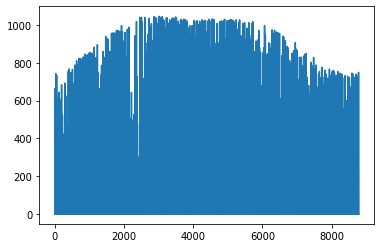

In [319]:
# sample METSTAT Glo output
test = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/2000/911650_2000_solar.csv')
plt.plot(test['METSTAT Glo (Wh/m^2)'])

Reading in USAF site information - from solar radiation dataset. <br/>
Filtering out class 1 stations (see NSRDB manual p.7-8 for more details)
- class 1: have complete period of record of 1991-2010
- class 2: have complete period of record but with significant periods of interpolated, filler, or otherwise low-quality input data for solar models
- class 3: have have some gaps in the period of record but have at least 3 years of data

In [21]:
df_sites = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/NSRDB_StationsMeta.csv')
print('all sites 1991-2010:', df_sites.shape[0])
df_sites.head()
df_class1 = df_sites[(df_sites['CLASS'] == 1)]
print('filtered class 1:', df_class1.shape[0])

all sites 1991-2010: 1454
filtered class 1: 242


In [33]:
%%time

sites_class1 = list(df_class1.USAF) # station list with class 1 quality
years = np.arange(1991,2011)
season_start, season_end = '03-01-', '11-30-' # setting a pretty borad range for growing season
df_solrad_all = pd.DataFrame()

for year in years:    
    print(year)
    df_solrad_sites = pd.DataFrame()
    
    for site in sites_class1:
        file = glob.glob('/home/disk/eos8/ach315/data/ISH_NSRD/' + str(year) + '/' + str(site) + '_*.csv')
        if len(file) == 1:
            df = pd.read_csv(file[0])
            date = df['YYYY-MM-DD']
            time = df['HH:MM (LST)']
            datetimes = []
        else: 
            print('multiple files!', file)

        # formatting time info
        for i in np.arange(len(time)):
            year, month, day = date[i].split('-')
            hour = int(time[i].split(':')[0]) - 1
            date_time = datetime.datetime(int(year), int(month), int(day), int(hour))
            datetimes.append(date_time)

        # reading in solar rad file and selecting for measurement
        df_solrad = pd.DataFrame(df['METSTAT Glo (Wh/m^2)'])
        df_solrad.columns = [site]    
        df_solrad.index = datetimes
        
        # concatting all sites within year
        df_solrad_sites = pd.concat([df_solrad_sites, df_solrad], axis=1, sort=True)
    
    # concatting all years
    df_solrad_all = pd.concat([df_solrad_all, df_solrad_sites], sort=True)

# convert missing values into NANs
df_solrad_all = df_solrad_all.replace({-9900: np.nan})

# storing outputs
#df_solrad_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_9110_class1.csv')

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
CPU times: user 46min 50s, sys: 13.4 s, total: 47min 3s
Wall time: 49min 47s
